In [521]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [522]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))}

# add an entry for -1
palette_dict[-1] = '#ffffff'


# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [523]:
# load the data from the xlsx file
df = pd.read_excel('../lc-project-data/2024-04-09-DATASET-ML.xlsx')


In [524]:
df.shape
from copy import deepcopy

preserved_df = deepcopy(df)
preserved_df.shape

(5801, 692)

## QA

In [525]:
# which columns are all nan?
nan_cols = preserved_df.columns[preserved_df.isna().all()].tolist()
print(nan_cols)

['other_hhx4', 'other_hhx5', 'other_hhx6', 'other_hhx7', 'other_hhx8', 'other_hhx9', 'other_hhx10', 'medication8', 'medication9', 'medication11', 'medication12', 'medication13', 'medication14', 'medication15', 'urine', 'pao2', 'sao2', 'ph', 'paco2', 'hco3', 'aexcess', 'alactate', 'clinical_note_upload']


In [526]:
# drop all columns that are fully NaN
df = df.dropna(axis = 1, how = "all")
df.shape

(5801, 669)

In [527]:
# adjunctive columns - remove adj2-adj10 as they are all zeroes
adj_cols = [col for col in preserved_df.columns if 'adj' in col]

In [528]:
to_drop = []

# drop gender column - mostly NaN
to_drop.append("gender")


In [529]:
try:
    df = df.drop(columns = to_drop)
except KeyError:
    pass
    # logging.error(f"Error: {e}")
df.shape

(5801, 668)

In [530]:
# get all column names
df_columns = df.columns

In [531]:
df["mode_of_diag"].value_counts()

mode_of_diag
1.0    3519
2.0     954
0.0     194
5.0      12
3.0       5
4.0       1
Name: count, dtype: int64

# FEATURE SETS

## LC+, LC-, HC

- make a new column to encode status of reach record

In [532]:
# LC_positive types
pos_vals = [2,4,6,8,9,12,13]
neg_vals = [1,5,7,10,]
hc_vals  = [3,11, 14,15]

LC_pos = df.query('participant_type in @pos_vals')
LC_neg = df.query('participant_type in @neg_vals')
HC     = df.query('participant_type in @hc_vals')


df['LC_STATUS'] = df['participant_type'].apply(lambda x: 'LC_POS' if x in pos_vals else 'LC_NEG' if x in neg_vals else 'HC')

df['LC_STATUS'].value_counts()

LC_STATUS
LC_NEG    3259
LC_POS    2461
HC          81
Name: count, dtype: int64

## DEMOGRAPHICS

In [533]:
# record id
RECORDS = ["record_id"]

# demographics etc
DEMOGRAPHICS = ["sex", 
                "age", 
                # "home_location", 
                # "living_with", 
                # "number_of_persons_in_house"
                ]
GEOGRAPHY    = ["country"]
EMPLOYMENT   = ["employed", 
                # "occupation", 
                "hcp", 
                "micro"
                ]
SITES        = ["dag"]


demographic_features = df[RECORDS + DEMOGRAPHICS + GEOGRAPHY + EMPLOYMENT + SITES]

demographic_features.shape

(5801, 8)

In [534]:
demographic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5801 entries, 0 to 5800
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   record_id  5801 non-null   object 
 1   sex        5747 non-null   float64
 2   age        5750 non-null   float64
 3   country    3674 non-null   float64
 4   employed   2079 non-null   float64
 5   hcp        3261 non-null   float64
 6   micro      3122 non-null   float64
 7   dag        5801 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 362.7+ KB


In [579]:
# how many nulls per site?
print("Missing HEALTH HISTORY values by site:")
df.groupby('dag')[RECORDS + DEMOGRAPHICS + GEOGRAPHY + EMPLOYMENT + SITES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing HEALTH HISTORY values by site:


dag,LDN,MTL,SAN,RIO,LUN
record_id,0,0,0,0,0
sex,0,0,0,1,53
age,3,0,0,2,46
country,9,333,228,129,1428
employed,57,2913,27,170,555
hcp,81,148,224,740,1347
micro,91,158,227,776,1427
dag,0,0,0,0,0


## PARTICIPANT TYPES

- summary for each participant type
- not a feature set
- information only

In [535]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

LC_STATUS,HC,LC_NEG,LC_POS
participant_type,,,
1,0,7,0
2,0,0,35
3,38,0,0
4,0,0,242
5,0,327,0
6,0,0,1607
7,0,1778,0
8,0,0,84
10,0,1147,0


## SITES

- summary of LC status by site
- not a feature set
- information only

In [536]:
site_name_dict = {1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                    4: 'RIO',
                    5: 'LUN',
}

In [537]:
# make a pivot table of the LC_STATUS by SITE
lc_site = df.pivot_table(index = 'dag', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

# map the dag index to the site name
lc_site.index = lc_site.index.map(site_name_dict)


lc_site

LC_STATUS,HC,LC_NEG,LC_POS
dag,,,
LDN,31,178,110
MTL,0,1997,916
SAN,3,71,227
RIO,9,128,659
LUN,38,885,549


## SUBSTANCES

In [538]:
# substances
# TODO: one hot encode substances
SUBSTANCES = [col for col in df_columns if "substances___" in col]


## MEDICATIONS
 - one hot encode

In [539]:
# medications
MEDTEMP = [col for col in df_columns if "medication" in col]
# drop medications that have a ___ in the name
MEDTEMP = [med for med in MEDTEMP if "___" not in med]


In [540]:
# read medications dict from json
import json

with open("./OUTPUT/dict-medications.json", "r") as f:
    medication_dict = json.load(f)

# cast key to int
medication_dict = {int(k): v for k, v in medication_dict.items()}

In [541]:

med_df = pd.DataFrame()

print(f">>> constructing binary columns for each unique medication")
# get all of the unique values in the medication columns
all_meds = df[MEDTEMP].values
# drop the empty strings from the_vals
all_meds = [[val for val in row if val != ""] for row in all_meds]

# fill nans with 0
all_meds = [[val if val == val else 0 for val in row] for row in all_meds]

# count the unique values in all_meds
unique_meds = np.unique(np.concatenate(all_meds))

print(f">>> \t- will add    {len(unique_meds):>4d} NEW columns")
print(f">>> \t- will remove {len(MEDTEMP):>4d} OLD columns")
print(f">>> \t- net change  {len(unique_meds) - len(MEDTEMP):>4d} columns")

# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the hx_df index as the index

encoded_meds = mlb.fit_transform(all_meds)
column_names = [f"meds_{med}" for med in mlb.classes_]
med_df = pd.DataFrame(encoded_meds, columns=column_names, index=df.index) # type: ignore

print(med_df.shape)


# drop the meds_0 column
try:
    med_df = med_df.drop(columns = "meds_0")
except KeyError:
    pass

# rename the columns using the medication_dict

for c in med_df.columns:

    # get the medication number from the column name
    mn = int(float(c.split("_")[1]))

    # look up the medication name in the medication_dict
    med_name = "MED-" + str.replace(medication_dict[mn], " ", "-")

    # rename the column
    med_df = med_df.rename(columns = {c: med_name})


>>> constructing binary columns for each unique medication
>>> 	- will add      28 NEW columns
>>> 	- will remove    8 OLD columns
>>> 	- net change    20 columns
(5801, 28)


In [542]:
# drop the original meds columns
try:
    df = df.drop(columns = MEDTEMP)
except KeyError:
    pass
# df = df.drop(columns = MEDICATIONS)

# concatenate the med_df with the original df
df = pd.concat([df, med_df], axis = 1)

# new name for medications
MEDICATIONS = med_df.columns.tolist()

medication_features = df[MEDICATIONS]

In [543]:
medication_features

,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,MED-Antiparasitics,MED-Antiparkinson-agents,MED-Antipsychotics,...,MED-Hormonal-agents-(adrenal),MED-Hormonal-agents-(sex-hormones),MED-Hormonal-agents-(thyroid),MED-Hormone-suppressant-(thyroid),MED-Immunological-agents,MED-Inflammatory-bowel-disease-agents,MED-Metabolic-bone-disease-agents,MED-Ophthalmic-agents,MED-Respiratory-tract-agents,MED-Skeletal-muscle-relaxants
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5797,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5798,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## HEALTH HISTORY

In [544]:
# find all columns with hhx in the name
HEALTH_GLOBAL = ["global"]
HHX_temp      = [col for col in df_columns if "past_hhx" in col]


In [545]:
# load a list of past hhx diags from the json file in OUTPUT

import json

with open("./OUTPUT/dict-past-hhx.json", "r") as f:
    past_hhx_dict = json.load(f)

# cast the key to an int
past_hhx_dict = {int(k): v for k, v in past_hhx_dict.items()}

In [546]:
# rename the past_hhx columns in df
for c in HHX_temp:

    # get the past_hhx number from the column name
    hhx = int(c.split("_")[-1])

    # look up the past_hhx name in the past_hhx_dict
    hhx_name = "HHX-" + str.replace(past_hhx_dict[hhx], " ", "-")

    # rename the column
    df = df.rename(columns = {c: hhx_name}) # type: ignore

HEALTH_HX = [col for col in df.columns if "HHX" in col]

In [547]:
# count HX items by site
hx_by_site = df.groupby("dag")[HEALTH_HX].sum()

# calculate the fraction of each hx item by site
# hx_by_site = hx_by_site.div(hx_by_site.sum(axis = 1), axis = 0)

# map index using site name dict
hx_by_site = hx_by_site.rename(index = site_name_dict)
hx_by_site.T

dag,LDN,MTL,SAN,RIO,LUN
HHX-Arterial-Hypertension,26.0,655.0,81.0,43.0,517.0
HHX-Pulmonary-hypertension,1.0,17.0,3.0,0.0,0.0
HHX-Cardiovascular-disease,17.0,193.0,38.0,0.0,88.0
HHX-Diabetes,22.0,344.0,70.0,22.0,185.0
HHX-Cancer,9.0,232.0,16.0,2.0,9.0
HHX-Immunosuppression,7.0,141.0,7.0,0.0,9.0
HHX-Chronic-lung-disease,6.0,105.0,11.0,0.0,11.0
HHX-Chronic-kidney-disease,5.0,136.0,12.0,0.0,7.0
HHX-Dialysis,1.0,15.0,0.0,0.0,0.0
HHX-Chronic-liver-disease,1.0,75.0,8.0,1.0,2.0


### `other_hhx` - one-hot encode


In [548]:
# read the other-hhx dict from json
import json

with open("./OUTPUT/dict-other-hx.json", "r") as f:
    other_hx_dict = json.load(f)


# cast key to int
other_hx_dict = {int(k): v for k, v in other_hx_dict.items()}

# map the other_hhx col from number to string
df["other_hhx"] = preserved_df["other_hhx"].map(other_hx_dict)

In [549]:
other_hhx_features = pd.get_dummies(df["other_hhx"], columns = ["other_hhx"], prefix = "OTHER-HHX", prefix_sep = "-")
# other_hhx_features

# cast the other_hhx columns to int
other_hhx_features = other_hhx_features.astype(int)


### Concatenate health history

In [550]:
# concatenate the health hx features with the other health hx features
hx_features_all = pd.concat([df[HEALTH_HX], other_hhx_features], axis = 1)

Text(0.5, 1.0, 'Health History Features')

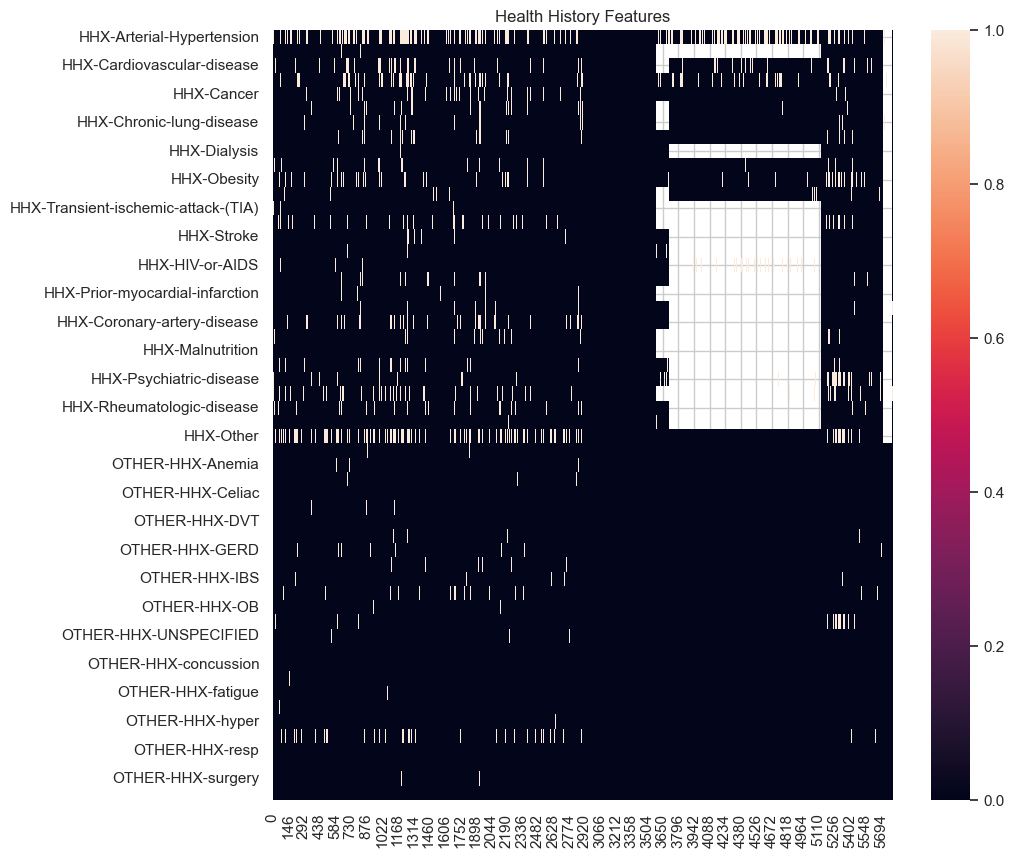

In [551]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(hx_features_all.T, cbar=True, ax = ax)
plt.title("Health History Features")

In [552]:
# how many nulls per site?
print("Missing HEALTH HISTORY values by site:")
df.groupby('dag')[HEALTH_HX].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing HEALTH HISTORY values by site:


dag,LDN,MTL,SAN,RIO,LUN
HHX-Arterial-Hypertension,60,0,0,0,0
HHX-Pulmonary-hypertension,81,0,0,121,1427
HHX-Cardiovascular-disease,74,0,0,121,0
HHX-Diabetes,66,0,0,0,0
HHX-Cancer,76,0,0,0,0
HHX-Immunosuppression,80,0,0,121,0
HHX-Chronic-lung-disease,76,0,0,121,0
HHX-Chronic-kidney-disease,81,0,0,0,0
HHX-Dialysis,81,0,0,0,1427
HHX-Chronic-liver-disease,81,0,0,0,0


## SURVEYS

<Axes: >

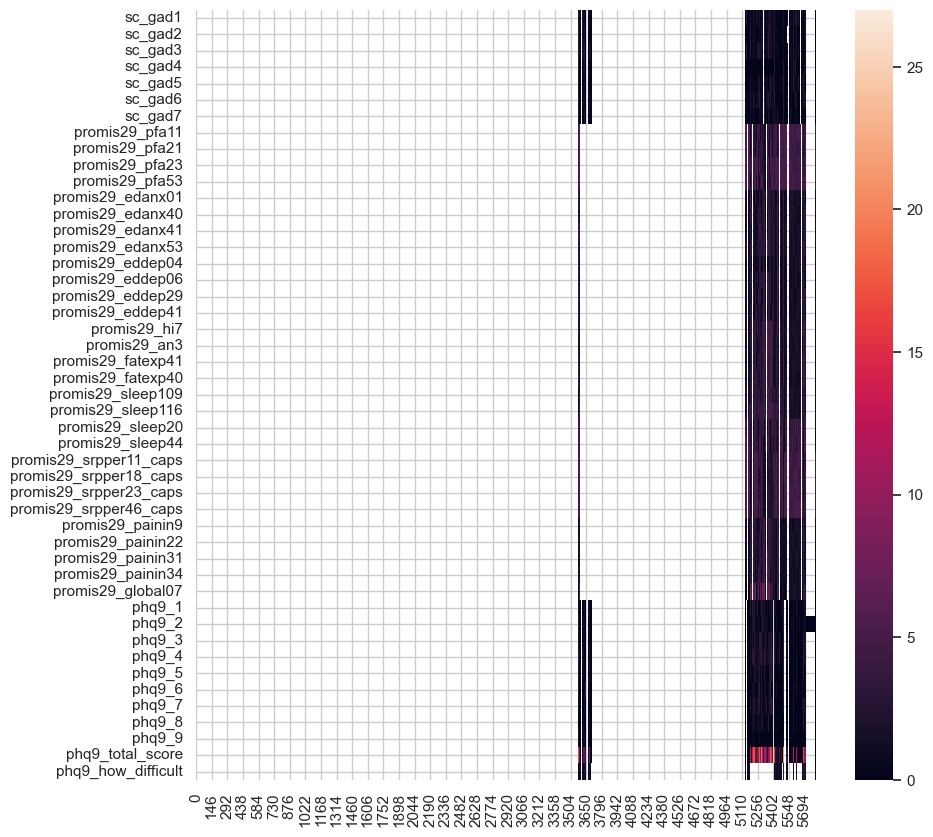

In [553]:
# add up the health history information

# surveys
GAD    = [col for col in df_columns if "_gad" in col]
PROMIS = [col for col in df_columns if "promis29" in col]
PHQ    = [col for col in df_columns if "phq" in col]

# remove gad_complete from GAD
GAD = [gad for gad in GAD if "complete" not in gad]

# completeness
PHX_COMPLETE    = ["phx_complete"]
PROMIS_COMPLETE = [col for col in df_columns if "promis_29_profile" in col]
PHQ_COMPLETE    = [col for col in df_columns if "patient_health_questionaire" in col]

SURVEYS = GAD + PROMIS + PHQ

survey_features = df[SURVEYS]

# plot it as a heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(survey_features.T, cbar=True, ax = ax)

In [554]:
# how many nulls per site?
print("Missing SURVEY values by site:")
df.groupby('dag')[SURVEYS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing SURVEY values by site:


dag,LDN,MTL,SAN,RIO,LUN
sc_gad1,99,2913,17,684,1417
sc_gad2,99,2913,18,684,1417
sc_gad3,98,2913,17,685,1417
sc_gad4,98,2913,17,684,1417
sc_gad5,98,2913,17,684,1417
sc_gad6,98,2913,17,684,1417
sc_gad7,98,2913,17,684,1417
promis29_pfa11,115,2913,22,780,1432
promis29_pfa21,115,2913,22,780,1432
promis29_pfa23,115,2913,22,780,1432


## SYMPTOMS

In [555]:
# read the list of symtpoms from the json file
import json
with open("./OUTPUT/list-symptoms.json", "r") as f:
    symptoms_list = json.load(f)

# get all columns that start with the symptoms list
SYMP = [col for col in df.columns if  col.startswith(tuple(symptoms_list))]

# feature set for symptoms
symptom_features = df[SYMP]


# fill nans with 0
symptom_features = symptom_features.fillna(0)

# there are symptom features with a value of 2 - replace with 1
symptom_features = symptom_features.replace(2, 1)

<Axes: >

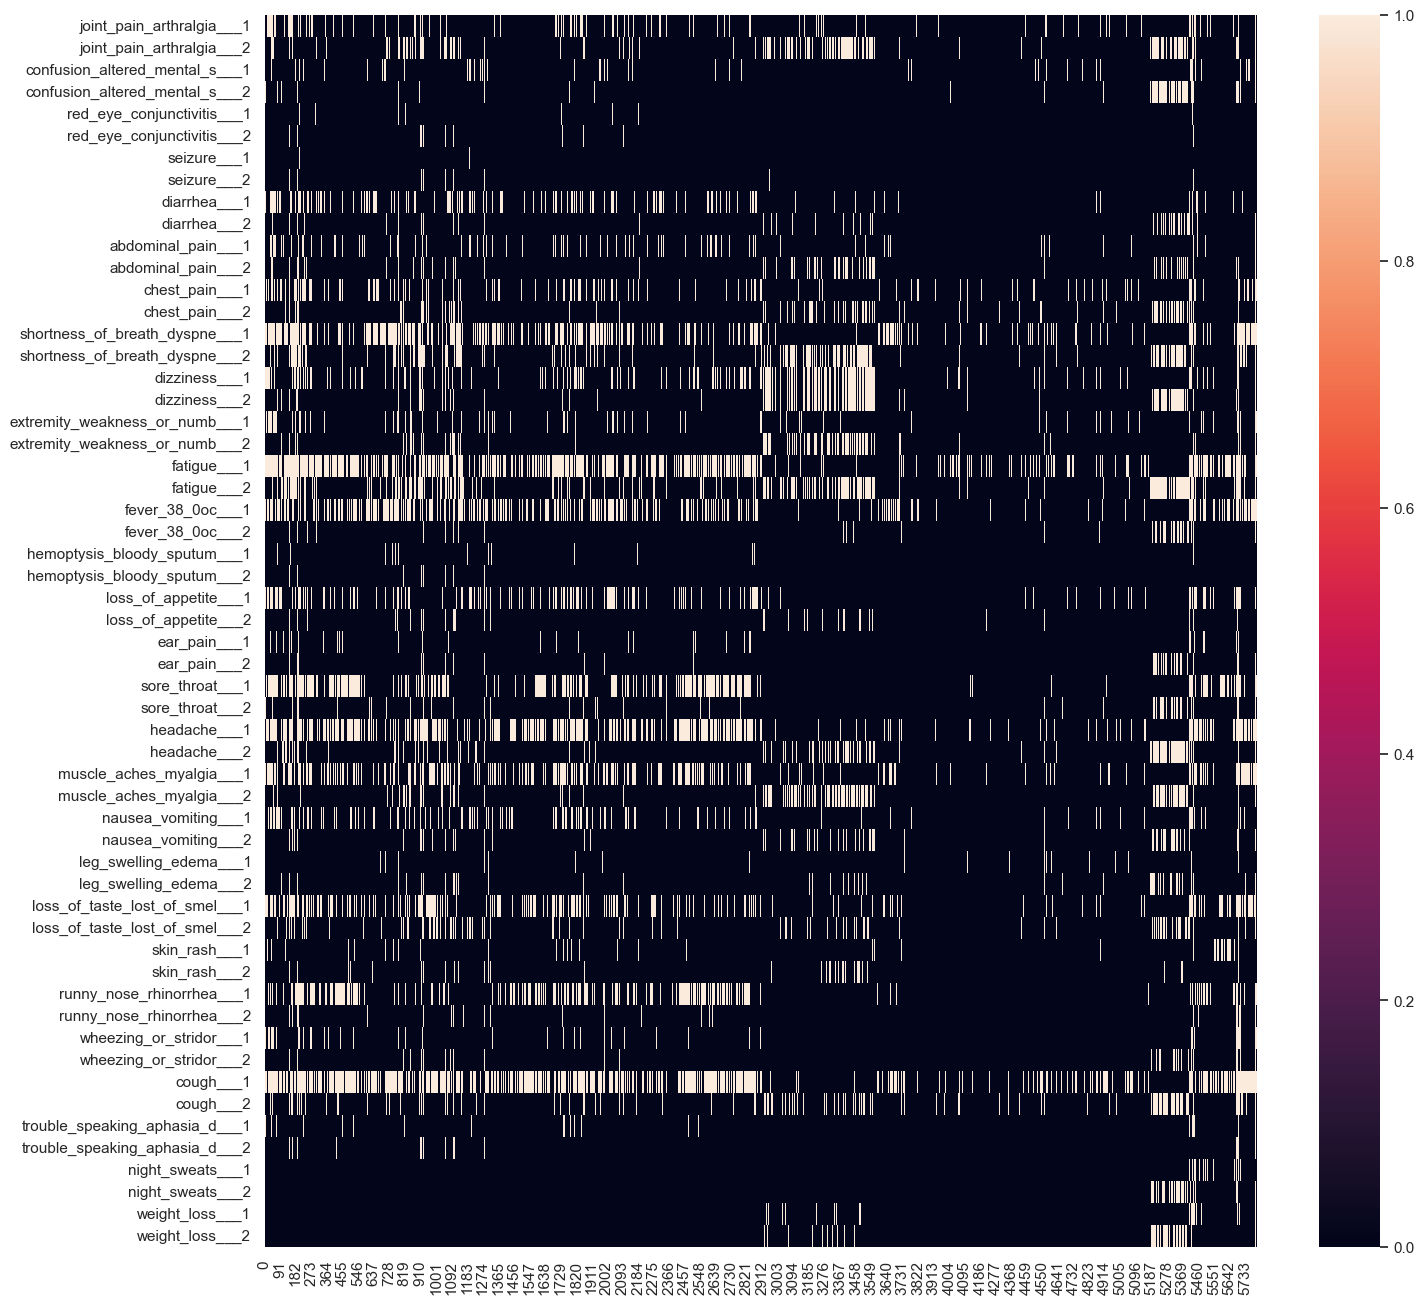

In [556]:
fig, ax = plt.subplots(figsize=(16,16))
# norm = mc.LogNorm(vmin=1, vmax=10)
sns.heatmap(symptom_features.T, cbar=True, ax = ax, norm = None)

## CLINICAL TESTS


In [557]:

s = "igg	wbc	neutrophil	neutrophil_count	lymphocyte	lymphocyte_count	monocyte	monocyte_count	eosinophil	eosinophil_count	basophil	basophil_count	platelets	haemoglobin	urea	creatinine	ntprobnp	bnp	sodium	potassium	crp	ldh	cpk	albumin		ast	alt	pct	troponinthigh	troponinihigh	troponint	troponini	aptt	inr	triglycerides	bilirubin	bilirubin_direct	glucose	fibrinogen	ferritin	il6	cd4	cd8	angiography	pocus	echocardiogram	echoresult	ekg	ekgresult	ekgcode	stented	cxr	cxrresult	cxrcode	cta	ctaresult	ctt	cttresult	cth	cthresult	imaging_results	imaging	spirometry	spirometryresult	metacholine	lung_function	lung_functionresult"
words = s.split()
words.sort()
CLINICAL_TESTS = words

# remove imaging_results from the list
CLINICAL_TESTS.remove("imaging_results")


# CLIN_TESTS_COMPLETE = [col for col in df_columns if "clinical_tests_complete" in col]

In [558]:
# remove columns that have less than 200 non-null points
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if df[col].count() > 200]

# drop features starting with ctt and cx
CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg"))]


Text(0.5, 1.0, 'Clinical Tests')

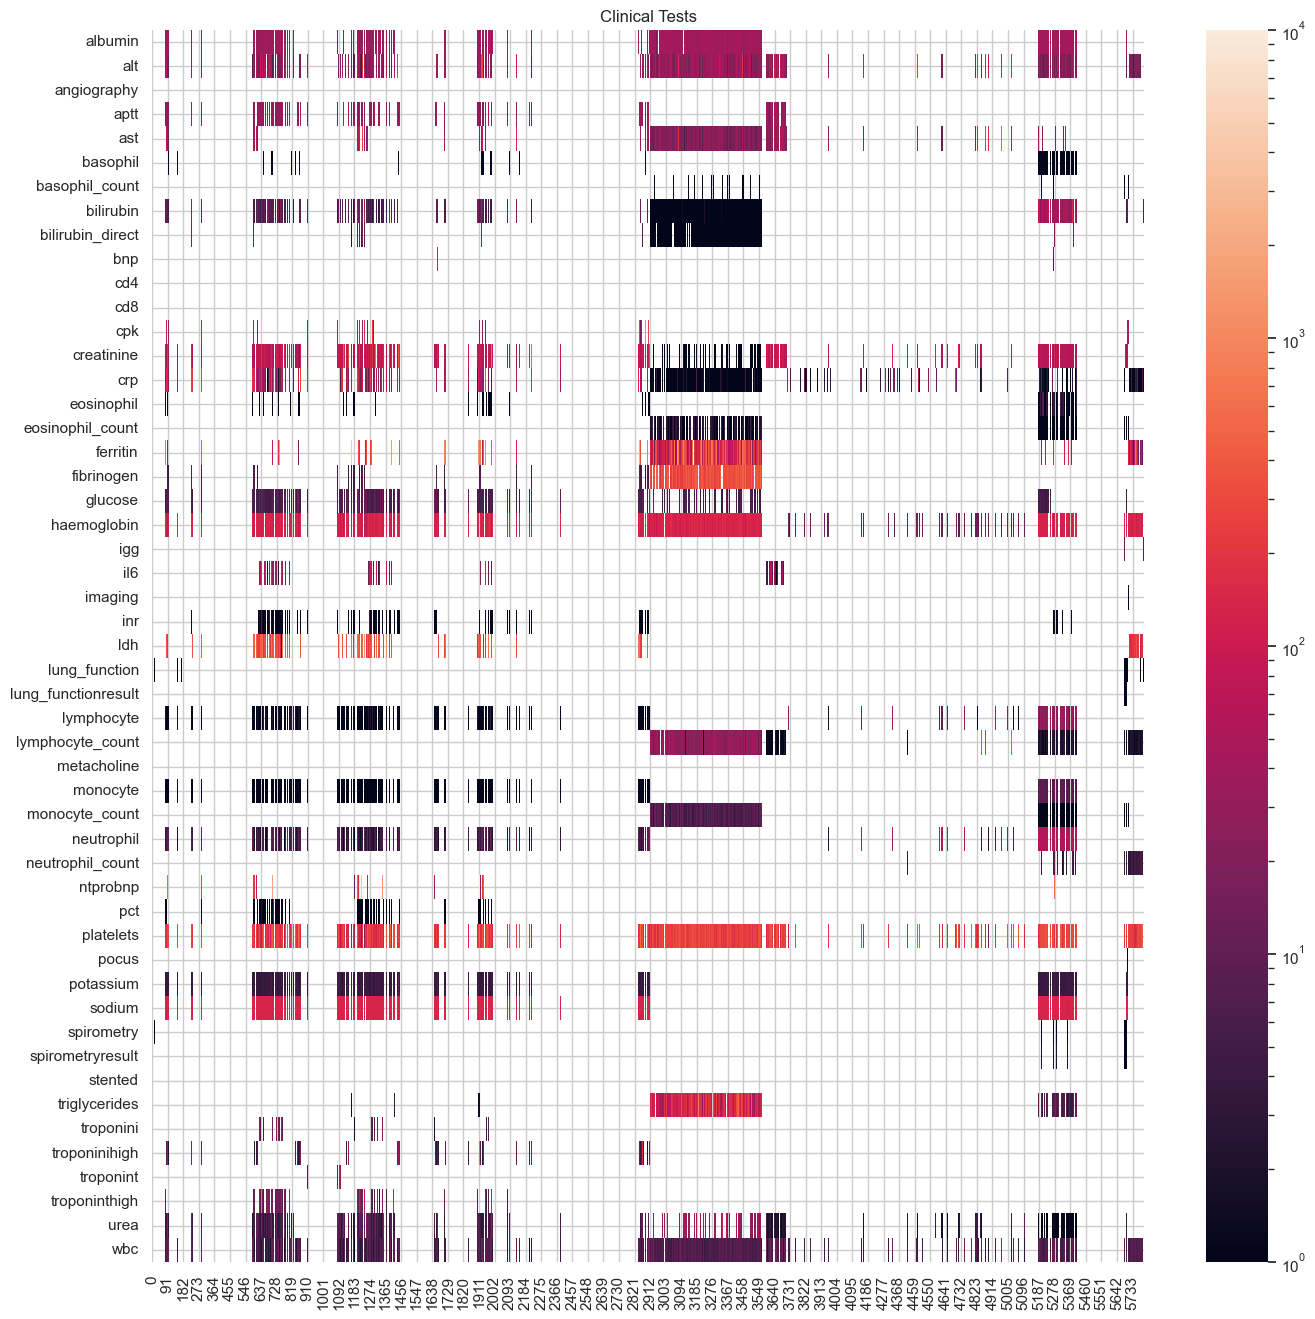

In [559]:
fig, ax = plt.subplots(figsize=(16,16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(df[CLINICAL_TESTS].T, cbar=True, ax = ax, norm = norm)
plt.title("Clinical Tests")

In [560]:
# how many nulls per site?
print("Missing CLINICAL values by site:")
df.groupby('dag')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing CLINICAL values by site:


dag,LDN,MTL,SAN,RIO,LUN
albumin,315,2395,105,160,1472
alt,246,2303,107,49,1378
angiography,312,2913,301,796,1472
aptt,318,2436,301,694,1472
ast,319,2728,268,49,1382
basophil,319,2523,123,796,1472
basophil_count,302,2913,123,151,1472
bilirubin,313,2323,104,156,1472
bilirubin_direct,319,2867,285,155,1472
bnp,319,2906,290,796,1472


In [561]:
from project_modules.data_prep import treat_outliers

b = treat_outliers(df[CLINICAL_TESTS], z_threshold = 3, method = "median")

df[CLINICAL_TESTS] = b

>>> Using z-threshold = 3.00 to identify outliers.
>>> There are 474 outliers in the data for abs(z) ≥ 3.00.
>>> Outliers are 8.17% of the total data.
>>> Replacing outliers with median.


/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/david/projects/lc2/project_modules/data_prep/_treat_outliers.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].mask(outlier_mask[col], median[col])


In [562]:
# sklearn median imputer

from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median')

# clinical_test_features = df[CLINICAL_TESTS].copy()
clinical_test_features =b.copy()

ctf_imputed = pd.DataFrame(imp.fit_transform(clinical_test_features), columns = clinical_test_features.columns)

print(ctf_imputed.shape)

(5801, 51)


In [563]:
clinical_features = ctf_imputed

Text(0.5, 1.0, 'Clinical Tests - Imputed with Median')

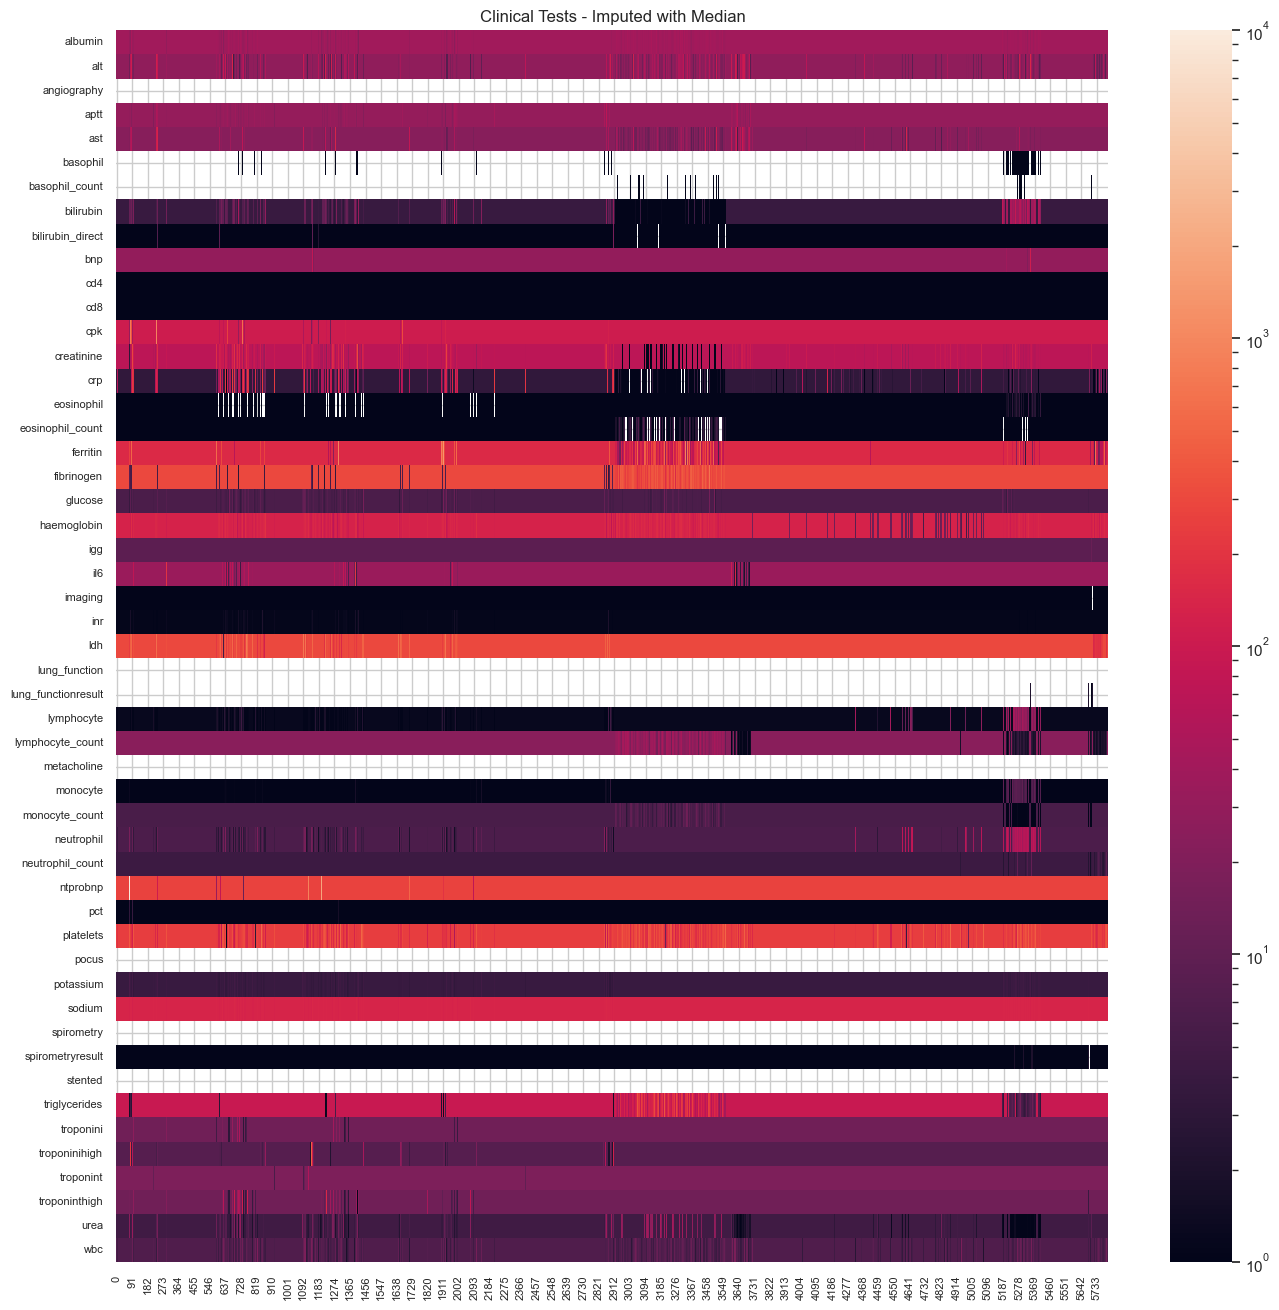

In [564]:
# plot the heatmap
fig, ax = plt.subplots(figsize=(16, 16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(clinical_features.T, cbar=True, ax = ax, norm = norm)
# set text size smaller
plt.xticks(fontsize=8); plt.yticks(fontsize=8);
plt.title("Clinical Tests - Imputed with Median")

## VACCINES

In [565]:
VAX_STATUS = ["vaccinated"]

# given a list of substrings, find aall columns that contain the substrings
def find_columns(df_columns, substrings):
    return [col for col in df_columns if any(substring in col for substring in substrings)]

VAX = find_columns(df_columns, ["astra_zeneca", "pfizer", "moderna", "j_j", "sinoppharm", "sinovac", "sputnik", "other___"])

# unstructured text - save for later?
VAX_SIDE_EFFECTS = find_columns(df_columns, ["vac_sideeffect"])

# fill in the missing values with 0
df[VAX] = df[VAX].fillna(0)

vax_features = df[VAX + VAX_STATUS]

In [566]:
vax_features.shape

(5801, 71)

Text(0.5, 1.0, 'Vaccination Status')

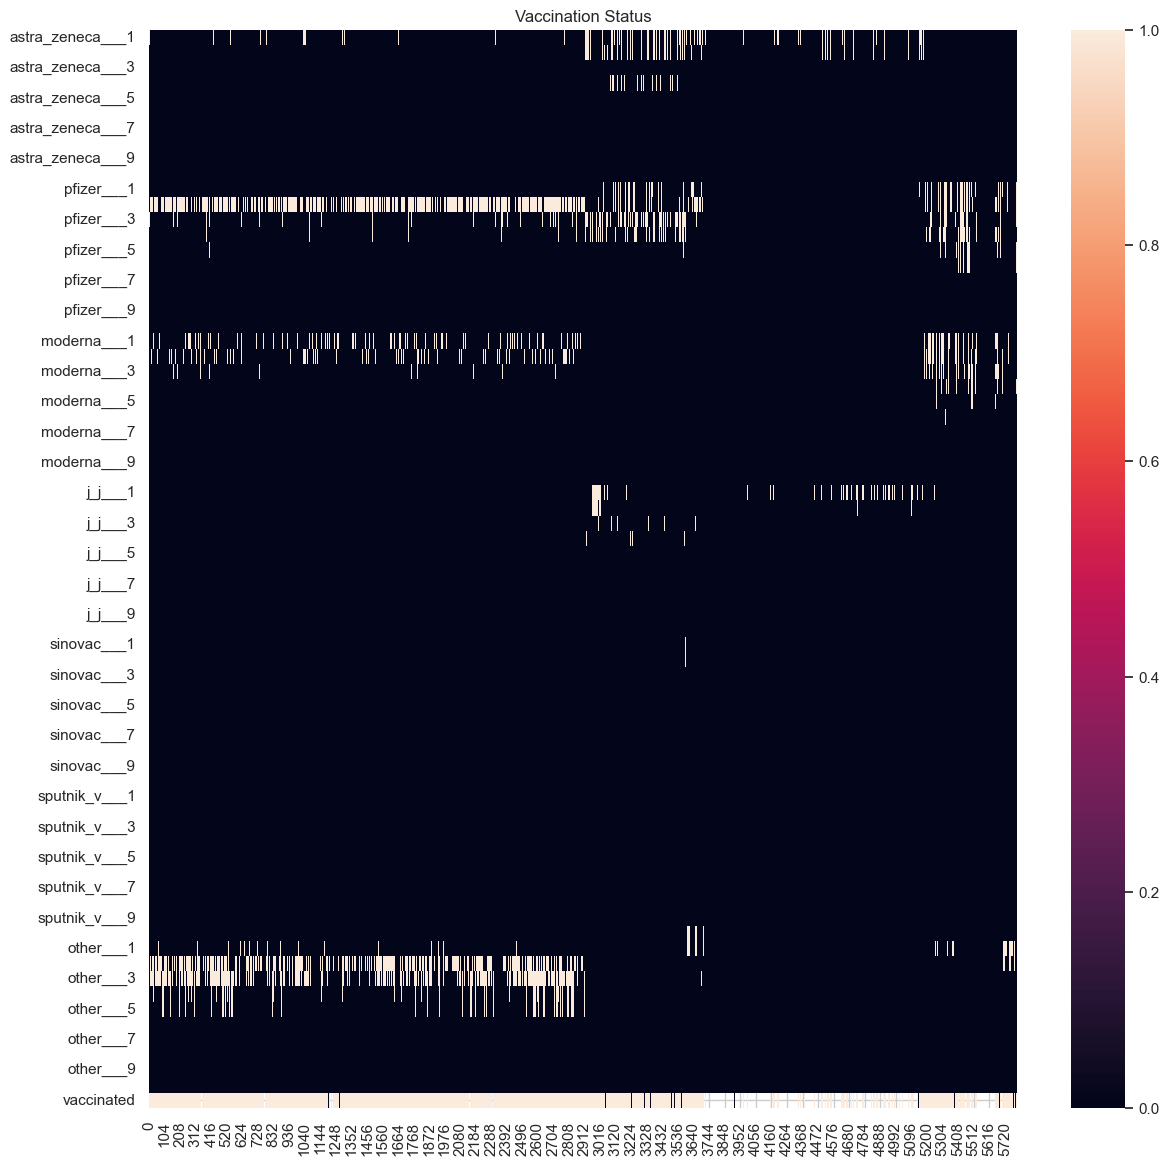

In [567]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 14))

sns.heatmap(vax_features.T, cbar=True, ax = ax, )
plt.title("Vaccination Status")

In [568]:
# how many nulls per site?
print("Missing VACCINE values by site:")
df.groupby('dag')[VAX + VAX_STATUS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing VACCINE values by site:


dag,LDN,MTL,SAN,RIO,LUN
astra_zeneca___1,0,0,0,0,0
astra_zeneca___2,0,0,0,0,0
astra_zeneca___3,0,0,0,0,0
astra_zeneca___4,0,0,0,0,0
astra_zeneca___5,0,0,0,0,0
...,...,...,...,...,...
other___7,0,0,0,0,0
other___8,0,0,0,0,0
other___9,0,0,0,0,0
other___10,0,0,0,0,0


# SAVE FEATURES TO FILE

- fill  na with 0 in vax, symptoms
- 

In [569]:
# demographic_features
# medication_features
# hx_features_all
# survey_features
# symptom_features
# clinical_features
# vax_features

# concatenate all of the features
features = pd.concat([
                        demographic_features, 
                        medication_features, 
                        hx_features_all, 
                        # survey_features, 
                        symptom_features, 
                        clinical_features, 
                        vax_features
                      ], axis = 1)

features["LC_STATUS"] = df["LC_STATUS"]

In [570]:
features.shape

(5801, 268)

In [577]:
# count the nulls per site
print("Missing values by site:")

features.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.sum()

Missing values by site:


dag
LDN     2683
MTL     3594
SAN      713
RIO     3170
LUN    31450
dtype: int64

<Axes: >

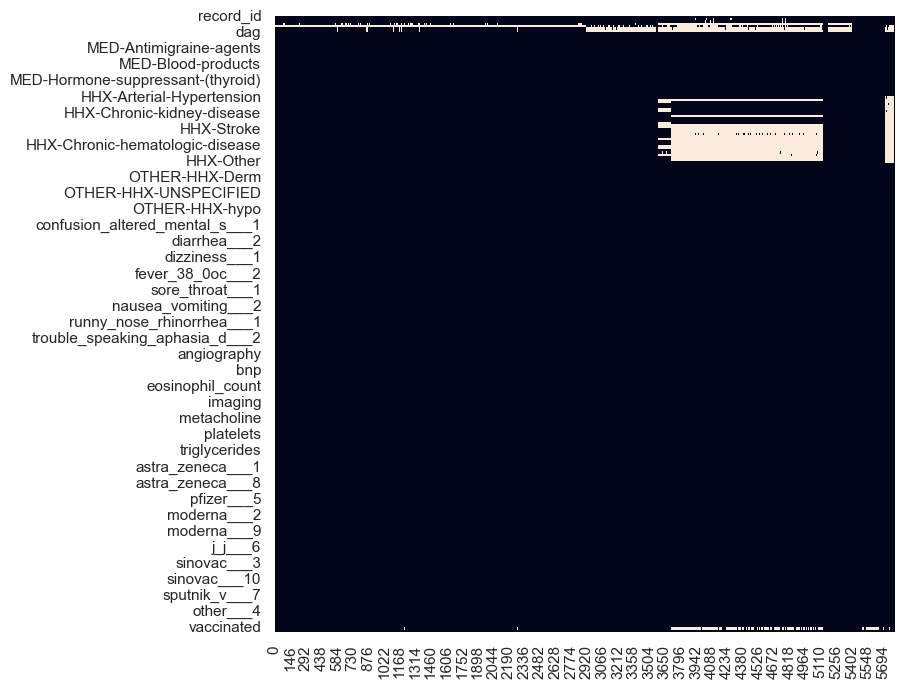

In [571]:
sns.heatmap(features.isnull().T, cbar=False)

In [572]:
# preserve the features dataframe
# features.to_pickle("../lc-project-data/features.pkl")

# save the features dataframe to an excel file
features.to_excel("../lc-project-data/features.xlsx")

# save the features dataframe to a csv file
# features.to_csv("../lc-project-data/features.csv")

